# Pet Image Colorization in LAB Space

- Task: Given a grayscale pet image (L channel), predict chrominance (ab) and reconstruct RGB.
- Dataset: Oxford-IIIT Pet Dataset.
- Models:
  1. Baseline CNN encoder-decoder
  2. Custom U-Net
  3. U-Net with VGG16 encoder

### Section 1 - Imports & global config

In [11]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from skimage.metrics import structural_similarity

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

### Section 2 - LAB helpers + metrics + visualization

In [4]:
def lab_to_rgb(L, ab):
  L = L.detach().cpu().numpy()
  ab = ab.detach().cpu().numpy()

  batch_size, num_channels, height, width = L.shape

  L = (L[:, 0] * 255.0).clip(0, 255)
  A = (ab[:, 0] * 128.0 + 128.0).clip(0, 255)
  B = (ab[:, 1] * 128.0 + 128.0).clip(0, 255)

  lab = np.zeros((batch_size, height, width, 3), dtype=np.float32)
  lab[:, :, :, 0] = L
  lab[:, :, :, 1] = A
  lab[:, :, :, 2] = B

  rgbs = []
  for i in range(batch_size):
    rgb_img = cv2.cvtColor(lab[i].astype("uint8"), cv2.COLOR_LAB2RGB)
    rgb = rgb_img.astype(np.float32) / 255.0
    rgbs.append(rgb)

  return np.stack(rgbs, axis=0)


In [57]:
from math import log10
from skimage.metrics import structural_similarity

def psnr(actual, pred):
  actual = actual.astype(np.float32)
  pred = pred.astype(np.float32)

  mse = np.mean((actual - pred) ** 2)
  if mse == 0:
    return float('inf')

  MAX = 1.0
  return 10 * log10((MAX ** 2) / mse)

def ssim(actual, pred):
  actual = actual.astype(np.float32)
  pred = pred.astype(np.float32)
  return structural_similarity(
      actual,
      pred,
      data_range=1.0,
      channel_axis=-1
  )

In [54]:
def visualize_sample(rgb_true, rgb_pred, grayscale):
  def to_display(img):
    img = np.asarray(img)
    if img.dtype == np.uint8:
        return img.astype(np.float32) / 255.0
    return np.clip(img, 0.0, 1.0)

  rgb_true = to_display(rgb_true)
  rgb_pred = to_display(rgb_pred)

  plt.figure(figsize=(10,3))

  plt.subplot(1,3,1)
  plt.title("Ground Truth")
  plt.imshow(rgb_true)
  plt.axis("off")

  plt.subplot(1,3,2)
  plt.title("Grayscale")
  plt.imshow(grayscale, cmap="gray", vmin=0, vmax=1)
  plt.axis("off")

  plt.subplot(1,3,3)
  plt.title("Prediction")
  plt.imshow(rgb_pred)
  plt.axis("off")

  plt.tight_layout()
  plt.show()

In [38]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, train_accs=None, val_accs=None):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot losses
    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, train_losses, color=color, label='Training Loss')
    ax1.plot(epochs, val_losses, color='tab:orange', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot accuracies if provided
    if train_accs and val_accs:
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Accuracy (%)', color=color)
        ax2.plot(epochs, train_accs, color=color, linestyle='--', label='Training Acc')
        ax2.plot(epochs, val_accs, color='tab:green', linestyle='--', label='Validation Acc')
        ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title('Training and Validation Metrics')
    plt.show()

### Section 3 - Dataset & Dataloaders

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import cv2
import torch
from torchvision import transforms

class ColorizationDatasetVGG(Dataset):
    def __init__(self, paths, unet_transform=None, vgg_transform=None):
        self.paths = paths
        self.unet_transform = unet_transform
        self.vgg_transform = vgg_transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")

        rgb_np = np.array(image)
        lab = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2LAB).astype(np.float32)
        L = lab[:, :, 0] / 255.0
        A = (lab[:, :, 1] - 128.0) / 128.0
        B = (lab[:, :, 2] - 128.0) / 128.0
        L = np.expand_dims(L, axis=0)
        AB = np.stack([A, B], axis=0)

        if self.unet_transform:
            L = torch.tensor(L, dtype=torch.float32)
            AB = torch.tensor(AB, dtype=torch.float32)
            L = torch.nn.functional.interpolate(L.unsqueeze(0), size=(128,128), mode='bilinear', align_corners=False).squeeze(0)
            AB = torch.nn.functional.interpolate(AB.unsqueeze(0), size=(128,128), mode='bilinear', align_corners=False).squeeze(0)
        else:
            L = torch.tensor(L, dtype=torch.float32)
            AB = torch.tensor(AB, dtype=torch.float32)

        if self.vgg_transform:
            image_vgg = self.vgg_transform(image)
        else:
            image_vgg = transforms.ToTensor()(image)

        return L, AB, image_vgg


In [45]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]

        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if isinstance(image, torch.Tensor):
            img_np = image.detach().cpu().numpy()
            if img_np.ndim == 3 and img_np.shape[0] in (1, 3):
                img_np = np.transpose(img_np, (1, 2, 0))  # C,H,W -> H,W,C
            if img_np.max() <= 1.0:
                img_np = (img_np * 255.0).clip(0, 255)
            rgb = img_np.astype(np.uint8)

        elif isinstance(image, np.ndarray):
            rgb = image
            if rgb.ndim == 3 and rgb.shape[0] in (1, 3) and rgb.shape[2] not in (1, 3):
                rgb = np.transpose(rgb, (1, 2, 0))
            if rgb.dtype != np.uint8:
                if rgb.max() <= 1.0:
                    rgb = (rgb * 255.0).clip(0, 255).astype(np.uint8)
                else:
                    rgb = rgb.astype(np.uint8)
        else:
            rgb = np.array(image, dtype=np.uint8)

        lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB).astype(np.float32)

        L = lab[:, :, 0] / 255.0                # [0,1]
        A = (lab[:, :, 1] - 128.0) / 128.0      # ~[-1,1]
        B = (lab[:, :, 2] - 128.0) / 128.0

        L = np.expand_dims(L, axis=0)           # (1,H,W)
        AB = np.stack([A, B], axis=0)           # (2,H,W)

        return L.astype("float32"), AB.astype("float32")

In [14]:
from google.colab import drive
from pathlib import Path
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/ee541-final-project/oxford-iiit-pet/images"

image_paths = sorted(Path(dataset_path).glob("*.jpg"))
print("Total images:", len(image_paths))

train_paths, temp_paths = train_test_split(image_paths, test_size=0.3, random_state=SEED)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 7390


In [46]:
resize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
])

vgg_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_ds = ColorizationDataset(train_paths, transform=resize_transform)
val_ds = ColorizationDataset(val_paths, transform=resize_transform)
test_ds = ColorizationDataset(test_paths, transform=resize_transform)

vgg_train_ds = ColorizationDatasetVGG(train_paths, unet_transform=True, vgg_transform=vgg_transform)
vgg_val_ds = ColorizationDatasetVGG(val_paths, unet_transform=True, vgg_transform=vgg_transform)
vgg_test_ds = ColorizationDatasetVGG(test_paths, unet_transform=True, vgg_transform=vgg_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

vgg_train_loader = DataLoader(vgg_train_ds, batch_size=BATCH_SIZE, shuffle=True)
vgg_val_loader = DataLoader(vgg_val_ds, batch_size=BATCH_SIZE, shuffle=False)
vgg_test_loader = DataLoader(vgg_test_ds, batch_size=BATCH_SIZE, shuffle=False)

### Section 4 - Training/eval utilities

In [68]:
def evaluate_model(model, data_loader, device, max_visualize=3):
    model.to(device)
    model.eval()

    psnr_scores, ssim_scores = [], []
    shown = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if len(batch) == 2:
                L, ab = batch
                inputs = L.to(device)          # model takes L
            else:
                L, ab, vgg_input = batch
                inputs = vgg_input.to(device)  # model takes VGG input

            L = L.to(device)
            ab = ab.to(device)

            pred_ab = model(inputs)

            true_rgb_batch = lab_to_rgb(L, ab)        # (B,H,W,3) in [0,1]
            pred_rgb_batch = lab_to_rgb(L, pred_ab)

            for i in range(pred_rgb_batch.shape[0]):
                true_rgb = true_rgb_batch[i]
                pred_rgb = pred_rgb_batch[i]
                gray = L[i].cpu().numpy().squeeze()

                if shown < max_visualize:
                    visualize_sample(true_rgb, pred_rgb, gray)
                    shown += 1

                psnr_scores.append(psnr(true_rgb, pred_rgb))
                ssim_scores.append(ssim(true_rgb, pred_rgb))

            if shown >= max_visualize:
                break

    mean_psnr = float(np.mean(psnr_scores))
    mean_ssim = float(np.mean(ssim_scores))
    print(f"\nFinal PSNR: {mean_psnr:.2f}, SSIM: {mean_ssim:.4f}")
    return mean_psnr, mean_ssim

In [42]:
import copy

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, num_epochs=20, patience=5, device=DEVICE):
  model.to(device)
  best_val_loss = float("inf")
  best_state = copy.deepcopy(model.state_dict())
  history = {"train_loss": [], "val_loss": []}

  epochs_no_improve = 0

  for epoch in range(num_epochs):
      model.train()
      running_train = 0.0
      for batch in train_loader:
          if len(batch) == 2:
              L, ab = batch
              inputs = L.to(device)
          else:
              L, ab, vgg_input = batch
              inputs = vgg_input.to(device)
          targets = ab.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          running_train += loss.item() * inputs.size(0)

      train_loss = running_train / len(train_loader.dataset)

      model.eval()
      running_val = 0.0
      with torch.no_grad():
          for batch in val_loader:
              if len(batch) == 2:
                  L, ab = batch
                  inputs = L.to(device)
              else:
                  L, ab, vgg_input = batch
                  inputs = vgg_input.to(device)
              targets = ab.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              running_val += loss.item() * inputs.size(0)

      val_loss = running_val / len(val_loader.dataset)
      history["train_loss"].append(train_loss)
      history["val_loss"].append(val_loss)
      print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f} Val: {val_loss:.4f}")

      if scheduler is not None:
          scheduler.step(val_loss)

      if val_loss < best_val_loss - 1e-6:
          best_val_loss = val_loss
          best_state = model.state_dict().copy()
          epochs_no_improve = 0
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= patience:
              print(
                  f"Early stopping at epoch {epoch+1} "
                  f"(no improvement for {patience} epochs)."
              )
              break


  model.load_state_dict(best_state)
  return model, history

### Section 5- Baseline Model

Epoch 1/20 - Train: 0.0103 Val: 0.0097
Epoch 2/20 - Train: 0.0100 Val: 0.0097
Epoch 3/20 - Train: 0.0099 Val: 0.0094
Epoch 4/20 - Train: 0.0099 Val: 0.0096
Epoch 5/20 - Train: 0.0099 Val: 0.0094
Epoch 6/20 - Train: 0.0098 Val: 0.0094
Epoch 7/20 - Train: 0.0098 Val: 0.0094
Epoch 8/20 - Train: 0.0097 Val: 0.0093
Epoch 9/20 - Train: 0.0098 Val: 0.0094
Epoch 10/20 - Train: 0.0097 Val: 0.0094
Epoch 11/20 - Train: 0.0097 Val: 0.0094
Epoch 12/20 - Train: 0.0097 Val: 0.0093
Epoch 13/20 - Train: 0.0097 Val: 0.0093
Early stopping at epoch 13 (no improvement for 5 epochs).

BATCH 0
  L   min/max: 0.0 1.0
  GT  ab min/max: -0.4140625 0.578125
  Pred ab min/max: -0.030686169862747192 0.1375921070575714
  GT RGB min/max: 0.0 1.0
  Pred RGB min/max: 0.0 1.0


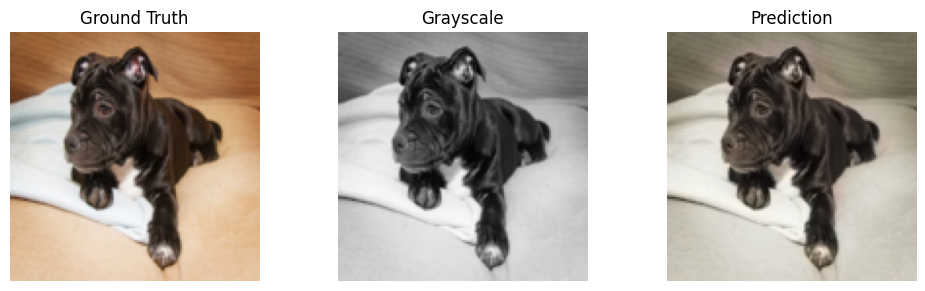

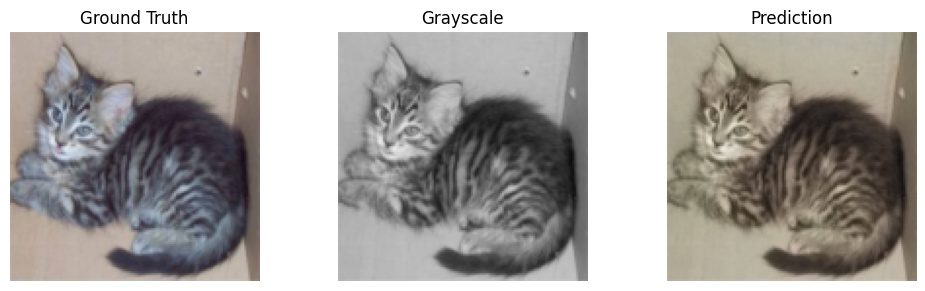

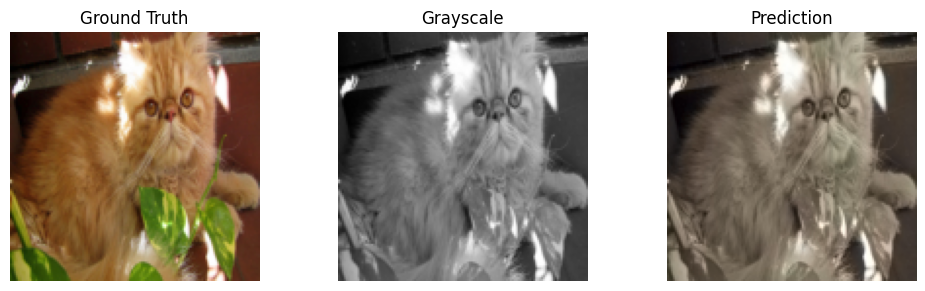


Final PSNR: 23.90, SSIM: 0.9305


In [59]:
import torch
import torch.nn as nn

baseline = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),

    nn.Tanh()
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline, history = train_model(
    baseline,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    device=device
)

psnr_base, ssim_base = evaluate_model(baseline, test_loader, device)

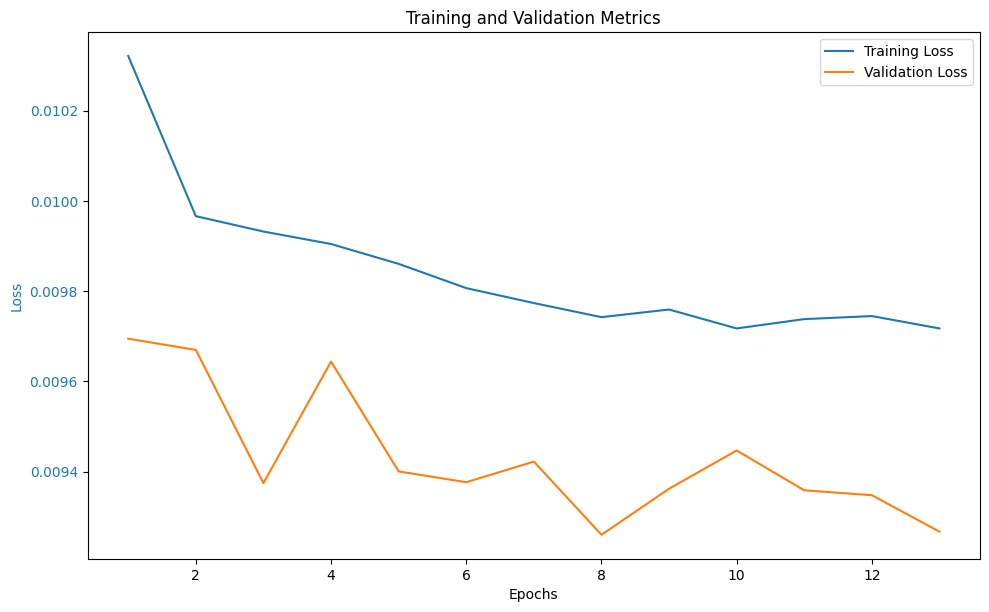

In [60]:
plot_learning_curves(history["train_loss"], history["val_loss"])

#### TODO: Explain limitations

### Section 6 - Custom U-Net

Epoch 1/20 - Train: 0.0868 Val: 0.0661
Epoch 2/20 - Train: 0.0681 Val: 0.0647
Epoch 3/20 - Train: 0.0663 Val: 0.0644
Epoch 4/20 - Train: 0.0660 Val: 0.0641
Epoch 5/20 - Train: 0.0658 Val: 0.0644
Epoch 6/20 - Train: 0.0656 Val: 0.0639
Epoch 7/20 - Train: 0.0656 Val: 0.0636
Epoch 8/20 - Train: 0.0653 Val: 0.0635
Epoch 9/20 - Train: 0.0650 Val: 0.0628
Epoch 10/20 - Train: 0.0649 Val: 0.0628
Epoch 11/20 - Train: 0.0650 Val: 0.0633
Epoch 12/20 - Train: 0.0648 Val: 0.0628
Epoch 13/20 - Train: 0.0646 Val: 0.0628
Epoch 14/20 - Train: 0.0645 Val: 0.0622
Epoch 15/20 - Train: 0.0644 Val: 0.0620
Epoch 16/20 - Train: 0.0643 Val: 0.0617
Epoch 17/20 - Train: 0.0640 Val: 0.0616
Epoch 18/20 - Train: 0.0639 Val: 0.0618
Epoch 19/20 - Train: 0.0638 Val: 0.0621
Epoch 20/20 - Train: 0.0635 Val: 0.0628
Early stopping at epoch 20 (no improvement for 3 epochs).

BATCH 0
  L   min/max: 0.0 1.0
  GT  ab min/max: -0.4140625 0.578125
  Pred ab min/max: -0.12292134016752243 0.23552019894123077
  GT RGB min/max: 0.0

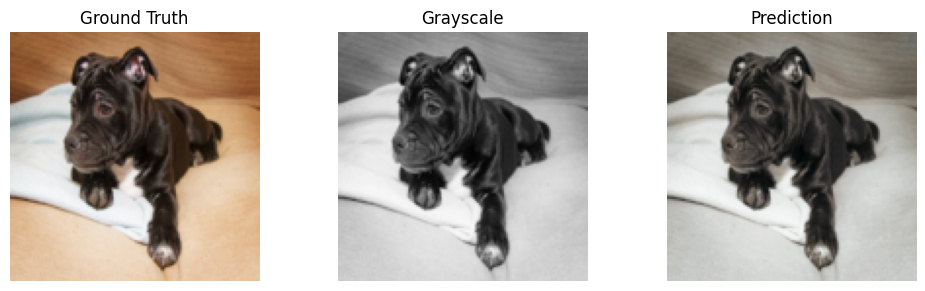

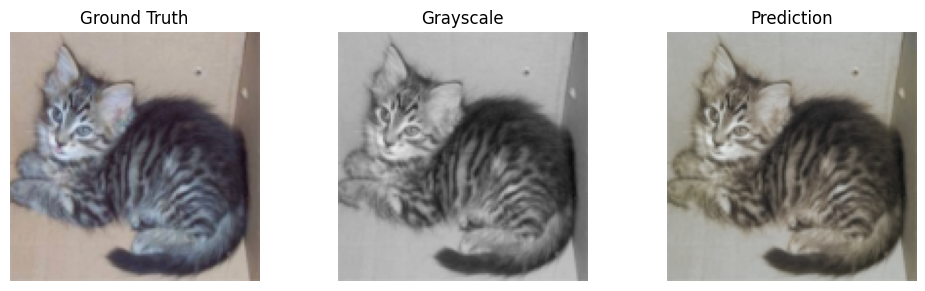

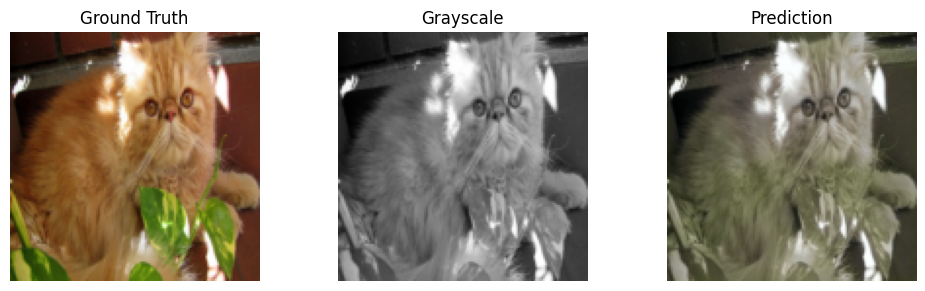


Final PSNR: 23.98, SSIM: 0.9303


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout=0.0):
    super().__init__()
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups=8, num_channels=out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups=8, num_channels=out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout > 0:
        layers.append(nn.Dropout2d(dropout))
    self.conv = nn.Sequential(*layers)

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, dropout=0.1):
    super().__init__()

    self.encoder1 = Conv2dBlock(1, 32)
    self.encoder2 = Conv2dBlock(32, 64)
    self.encoder3 = Conv2dBlock(64, 128)
    self.encoder4 = Conv2dBlock(128, 256)

    self.bottleneck = Conv2dBlock(256, 512)
    self.dropout_bottleneck = nn.Dropout(dropout)

    self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.decoder4 = Conv2dBlock(512, 256, dropout=dropout)

    self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.decoder3 = Conv2dBlock(256, 128, dropout=dropout)

    self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.decoder2 = Conv2dBlock(128, 64, dropout=dropout)

    self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    self.decoder1 = Conv2dBlock(64, 32, dropout=dropout)

    self.out = nn.Conv2d(32, 2, kernel_size=1)

  def forward(self, x):
    e1 = self.encoder1(x)
    e2 = self.encoder2(F.max_pool2d(e1, 2))
    e3 = self.encoder3(F.max_pool2d(e2, 2))
    e4 = self.encoder4(F.max_pool2d(e3, 2))

    b = self.bottleneck(F.max_pool2d(e4, 2))
    b = self.dropout_bottleneck(b)

    d4 = self.up4(b)
    d4 = torch.cat([d4, e4], dim=1)
    d4 = self.decoder4(d4)

    d3 = self.up3(d4)
    d3 = torch.cat([d3, e3], dim=1)
    d3 = self.decoder3(d3)

    d2 = self.up2(d3)
    d2 = torch.cat([d2, e2], dim=1)
    d2 = self.decoder2(d2)

    d1 = self.up1(d2)
    d1 = torch.cat([d1, e1], dim=1)
    d1 = self.decoder1(d1)

    return torch.tanh(self.out(d1))

def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
      if m.bias is not None:
          nn.init.zeros_(m.bias)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.ones_(m.weight)
      nn.init.zeros_(m.bias)

unet = UNet(dropout=0.1)
unet.apply(init_weights)
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)
criterion = nn.L1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet, unet_history = train_model(
    unet,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    patience=3,
    scheduler=scheduler,
    device=device
)

psnr_unet, ssim_unet = evaluate_model(unet, test_loader, device)

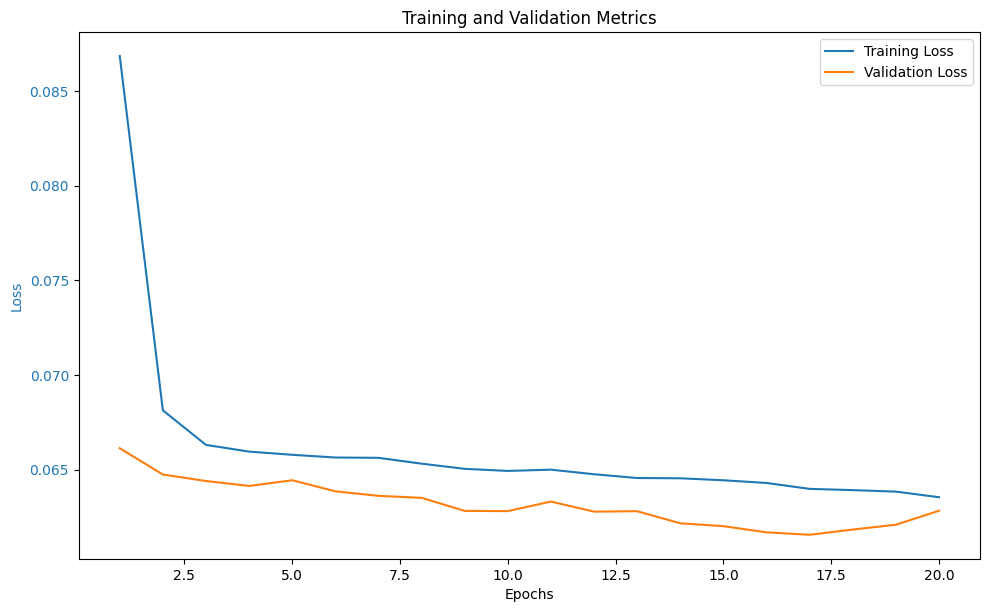

In [62]:
plot_learning_curves(unet_history["train_loss"], unet_history["val_loss"])

### Section 7 - U-Net with VGG16 Encoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Conv2dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dropout=0.0):
    super().__init__()
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups=8, num_channels=out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups=8, num_channels=out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout > 0:
        layers.append(nn.Dropout2d(dropout))
    self.conv = nn.Sequential(*layers)

  def forward(self, x):
    return self.conv(x)

class UNetVGGEncoder(nn.Module):
  def __init__(self, dropout=0.1):
    super().__init__()

    vgg = models.vgg16(pretrained=True).features

    self.encoder1 = nn.Sequential(*vgg[:4])
    self.encoder2 = nn.Sequential(*vgg[4:9])
    self.encoder3 = nn.Sequential(*vgg[9:16])
    self.encoder4 = nn.Sequential(*vgg[16:23])
    self.encoder5 = nn.Sequential(*vgg[23:30])

    for param in self.encoder1.parameters():
        param.requires_grad = False
    for param in self.encoder2.parameters():
        param.requires_grad = False

    self.bottleneck = Conv2dBlock(512, 512)
    self.dropout_bottleneck = nn.Dropout(dropout)

    self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.decoder4 = Conv2dBlock(512 + 512, 256, dropout=dropout)

    self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.decoder3 = Conv2dBlock(256 + 256, 128, dropout=dropout)

    self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.decoder2 = Conv2dBlock(128 + 128, 64, dropout=dropout)

    self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    self.decoder1 = Conv2dBlock(64 + 64, 32, dropout=dropout)

    self.out = nn.Conv2d(32, 2, kernel_size=1)

  def forward(self, x):
    e1 = self.encoder1(x)
    e2 = self.encoder2(e1)
    e3 = self.encoder3(e2)
    e4 = self.encoder4(e3)

    b = self.bottleneck(e4)

    d4 = F.interpolate(b, size=e4.shape[2:], mode='bilinear', align_corners=False)
    d4 = torch.cat([d4, e4], dim=1)
    d4 = self.decoder4(d4)

    d3 = F.interpolate(d4, size=e3.shape[2:], mode='bilinear', align_corners=False)
    d3 = torch.cat([d3, e3], dim=1)
    d3 = self.decoder3(d3)

    d2 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=False)
    d2 = torch.cat([d2, e2], dim=1)
    d2 = self.decoder2(d2)

    d1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)
    d1 = torch.cat([d1, e1], dim=1)
    d1 = self.decoder1(d1)

    return torch.tanh(self.out(d1))

unet_vgg = UNetVGGEncoder(dropout=0.1)
unet_vgg.apply(init_weights)
optimizer = torch.optim.AdamW(
    unet_vgg.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)
criterion = nn.SmoothL1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_vgg, unet_vgg_history = train_model(
      unet_vgg,
      train_loader=vgg_train_loader,
      val_loader=vgg_val_loader,
      optimizer=optimizer,
      criterion=criterion,
      num_epochs=20,
      patience=3,
      scheduler=scheduler,
      device=device
    )

psnr_unet_vgg, ssim_unet_vgg = evaluate_model(unet_vgg, vgg_test_loader, device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Train: 0.0070 Val: 0.0008
Epoch 2/20 - Train: 0.0010 Val: 0.0006
Epoch 3/20 - Train: 0.0007 Val: 0.0005
Epoch 4/20 - Train: 0.0006 Val: 0.0004
Epoch 5/20 - Train: 0.0006 Val: 0.0005
Epoch 6/20 - Train: 0.0006 Val: 0.0004
Epoch 7/20 - Train: 0.0005 Val: 0.0004
Epoch 8/20 - Train: 0.0005 Val: 0.0003
Epoch 9/20 - Train: 0.0005 Val: 0.0003
Epoch 10/20 - Train: 0.0004 Val: 0.0003
Epoch 11/20 - Train: 0.0004 Val: 0.0003
Epoch 12/20 - Train: 0.0004 Val: 0.0003
Epoch 13/20 - Train: 0.0004 Val: 0.0003
Epoch 14/20 - Train: 0.0004 Val: 0.0003
Epoch 15/20 - Train: 0.0004 Val: 0.0003
Epoch 16/20 - Train: 0.0004 Val: 0.0003
Epoch 17/20 - Train: 0.0004 Val: 0.0003
Epoch 18/20 - Train: 0.0004 Val: 0.0003
Epoch 19/20 - Train: 0.0004 Val: 0.0002


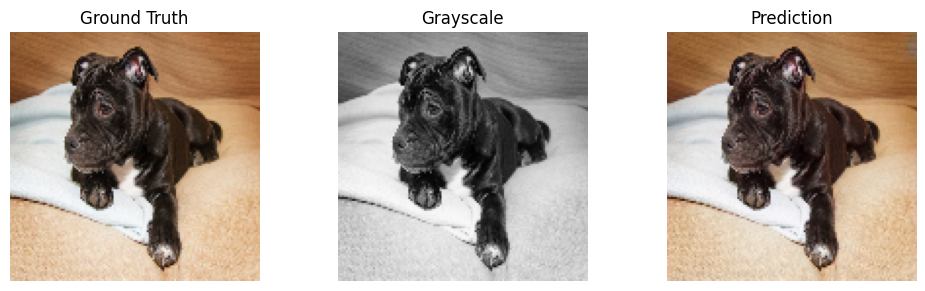

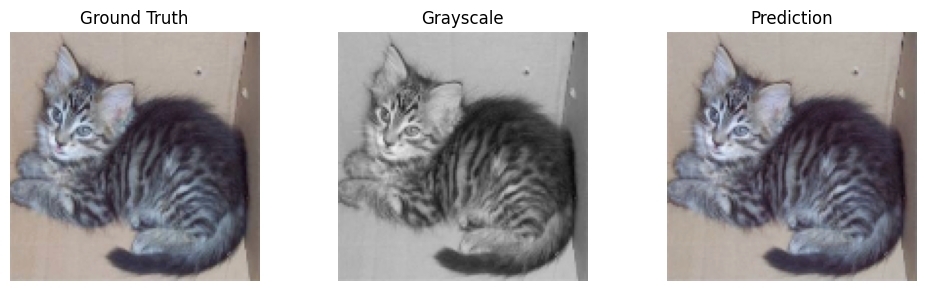

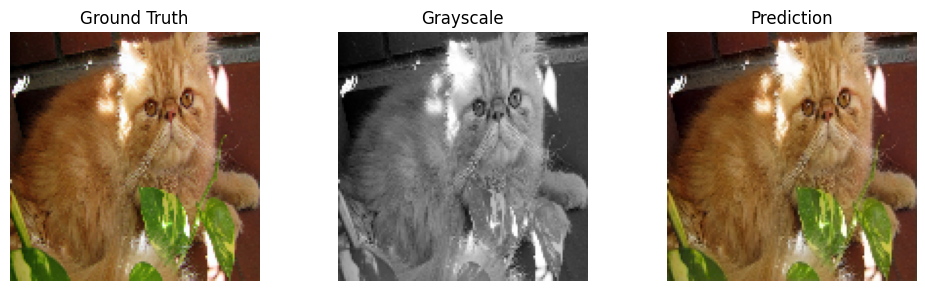


Final PSNR: 36.23, SSIM: 0.9789


In [69]:
psnr_unet_vgg, ssim_unet_vgg = evaluate_model(unet_vgg, vgg_test_loader, device)

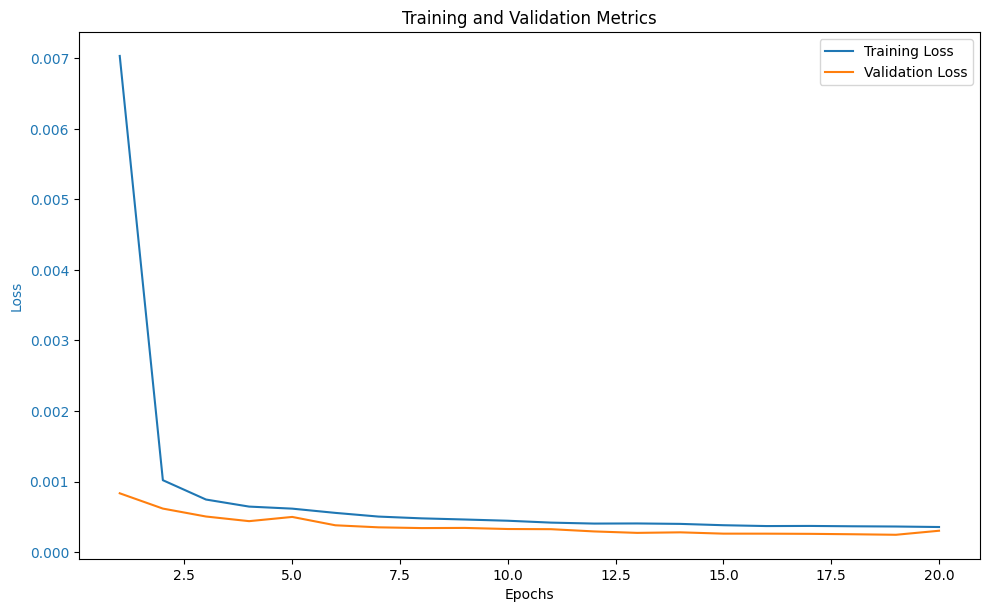

In [70]:
plot_learning_curves(unet_vgg_history["train_loss"], unet_vgg_history["val_loss"])

### Section 8 - Comparison & Discussion

In [71]:
results = {
    "Baseline": (psnr_base, ssim_base),
    "UNet": (psnr_unet, ssim_unet),
    "UNet + VGG16": (psnr_unet_vgg, ssim_unet_vgg),
}

for name, (p, s) in results.items():
    print(f"{name:15s}  PSNR: {p:.2f}  SSIM: {s:.4f}")

Baseline         PSNR: 23.90  SSIM: 0.9305
UNet             PSNR: 23.98  SSIM: 0.9303
UNet + VGG16     PSNR: 36.23  SSIM: 0.9789
